In [47]:
import numpy as np
import sys
sys.path.append("../model")
from rnn_FORCE import RNN
import matplotlib.pyplot as plt
import torch
from torch import tensor
from torch import nn
import seaborn as sns
from torch.autograd.functional import jacobian
from tqdm.notebook import tqdm
SAVEFIG = True

In [2]:
# Initializing matrix
num_nodes = 200
np.random.seed(3)  # 2

connectivity_matrix = np.ones((num_nodes, num_nodes))
weight_matrix = np.random.normal(0, 1/np.sqrt(num_nodes), (num_nodes, num_nodes))
for i in range(num_nodes):
    weight_matrix[i, i] = 0
    connectivity_matrix[i, i] = 0
output_weight_matrix = np.random.uniform(-1, 1, (1, num_nodes))
feedback_weight_matrix = np.random.uniform(-1, 1, (num_nodes, 1)) # * 0.5
init_state = np.random.uniform(-0.5, 0.5, (num_nodes, 1))
init_gain = np.ones((num_nodes, 1))
init_shift = np.zeros((num_nodes, 1))

In [3]:
# Dale's Law
excite_perc = 0.5
excite_num = int(excite_perc*num_nodes)
node_type = np.array([1]*excite_num + [-1]*(num_nodes-excite_num))
weight_type = np.tile(node_type, num_nodes).reshape(num_nodes, -1)

# Enforce Dale's Law
weight_matrix = np.abs(weight_matrix) * weight_type
output_weight_matrix = np.abs(output_weight_matrix) * node_type

# normalize
ext_weight_sum = num_nodes/4
inh_weight_sum = num_nodes/4
tmp_output_weight_matrix = output_weight_matrix.copy()
tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
output_weight_matrix = tmp_output_weight_matrix.copy()
init_output_weight_matrix = output_weight_matrix.copy()

In [4]:
# define targets
time_points = np.arange(8000)
half_period = 20
# targets = (np.sin((time_points+1)/60*np.pi))/4 + 0.5
targets = ((np.sin((time_points + 10)/half_period*np.pi))/4 + 0.5)

# inputs with different phases
np.random.seed(3)
inputs = []
for i in range(num_nodes):
    this_input = (np.sin((time_points + np.random.randint(0, half_period*2))/half_period*np.pi))/4 + 0.5
    inputs.append(this_input)
inputs = np.array(inputs)

In [5]:
# define sigmoid
def sigmoid_np(x):
    return 1 / (1 + np.exp(-x))

def inv_sigmoid_np(x):
    return -np.log((1 / x) - 1)

Must use activation as x rather than state. Otherwise, the output would not be a linear readout and depend on u.

In [6]:
# imitate rnn_FORCE
class mysys():
    def __init__(self, weight_matrix, connectivity_matrix, gain, shift, input_weight_matrix=None, inputs=None):
        # core parameters
        self.weight_matrix = weight_matrix
        self.connectivity_matrix = connectivity_matrix
        self.gain = gain
        self.shift = shift
        self.inputs = inputs
        self.input_weight_matrix = input_weight_matrix
        self.activation_func = nn.Sigmoid()
        
        # transfer into tensor
        self.weight_matrix_tensor = tensor(self.weight_matrix)
        self.gain_tensor = tensor(self.gain)
        self.shift_tensor = tensor(self.shift)
        
        # constants
        self.time_const = 1
        self.timestep = 0.1
        self.c = self.timestep / self.time_const
        self.g = 1.5
        self.i = 0

    def f_tensor(self, x_tensor, u_tensor, r_tensor):
        # this_input_tensor = torch.matmul(tensor(self.input_weight_matrix), tensor([[self.inputs[self.i]]]))
        y_tensor = (1 - self.c) * x_tensor \
            + self.c * self.activation_func((self.gain_tensor + u_tensor) * (self.g * torch.matmul(self.weight_matrix_tensor, x_tensor) + r_tensor - self.shift_tensor))
        return y_tensor
     
    def f(self, x, u, r):
        x_tensor = tensor(x)
        u_tensor = tensor(u)
        r_tensor = tensor(r)
        y_tensor = self.f_tensor(x_tensor, u_tensor, r_tensor)
        y = y_tensor.numpy()
        return y
    
    def jacob(self, x, u, r):
        x_tensor = tensor(x)
        u_tensor = tensor(u)
        r_tensor = tensor(r)
        dydx, dydu, dydr = jacobian(self.f_tensor,(x_tensor, u_tensor, r_tensor))
        Jx_tensor = dydx.squeeze(dim=(1,3))
        Ju_tensor = dydu.squeeze(dim=(1,3))
        Jr_tensor = dydr.squeeze(dim=(1,3))
        Jx = Jx_tensor.numpy()
        Ju = Ju_tensor.numpy()
        Jr = Jr_tensor.numpy()
        return Jx, Ju, Jr

# jnn_ff = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift, input_weight_matrix=feedback_weight_matrix, inputs=targets)
# jnn = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift, input_weight_matrix=feedback_weight_matrix, inputs=targets)
jnn_ff = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift)
jnn = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift)

### Simulate Without Control

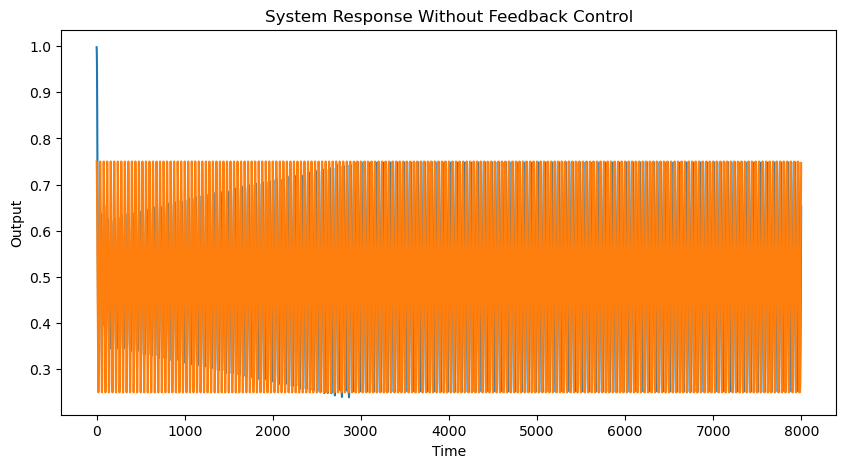

In [7]:
# Simulation Without Control
x = sigmoid_np(init_gain * init_state.copy() - init_shift)
u = init_state.copy() * 0
xs_ff_init, outputs_ff_init = [x], []
gainout= 5.5 # 1.15
shiftout= -5 # -2.5
out_lr = 0.002

for i in time_points[:-1]:
    
    # jnn_ff.i = i

    # output
    output_beforesig = output_weight_matrix @ x
    output = sigmoid_np(gainout * output_beforesig - shiftout)

    # adjust the gainout and shiftout
    period = 2 * half_period
    if i > period:
        mean_output = np.mean(outputs_ff_init[i-period:i])
        amplitude = np.max(outputs_ff_init[i-period:i]) - np.min(outputs_ff_init[i-period:i])
        if np.abs(mean_output - 0.5) > 0.01:
            shiftout += out_lr * np.sign(mean_output - 0.5)
        if np.abs(amplitude - 0.5) > 0.01:
            gainout -= out_lr * np.sign(amplitude - 0.5)

    # input
    this_input = inputs[:,i]
    r = feedback_weight_matrix * this_input.reshape(-1,1)

    # update x
    x1 = jnn_ff.f(x, u, r)
    x = x1.copy()
    
    # save
    xs_ff_init.append(x)
    outputs_ff_init.append(output.item())

# final readout for x_T
output_beforesig = output_weight_matrix @ x
output = sigmoid_np(gainout * output_beforesig - shiftout)
outputs_ff_init.append(output.item())

# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_ff_init)
plt.plot(time_points, targets)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

In [8]:
gainout, shiftout

(10.944000000000708, -9.71000000000024)

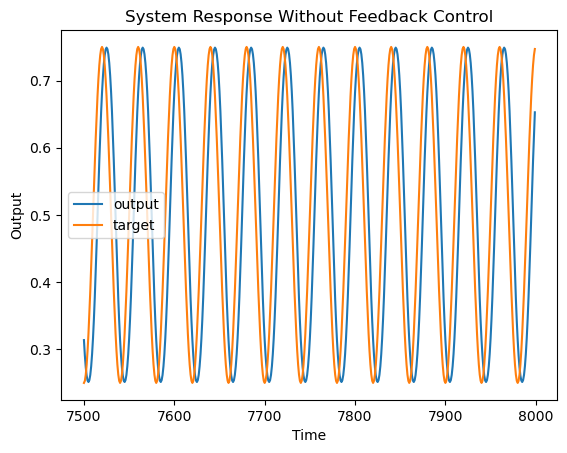

In [9]:
# Plot the output
plt.plot(time_points[-500:], outputs_ff_init[-500:], label='output')
plt.plot(time_points[-500:], targets[-500:], label='target')
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_ff_outputs_0424.png")

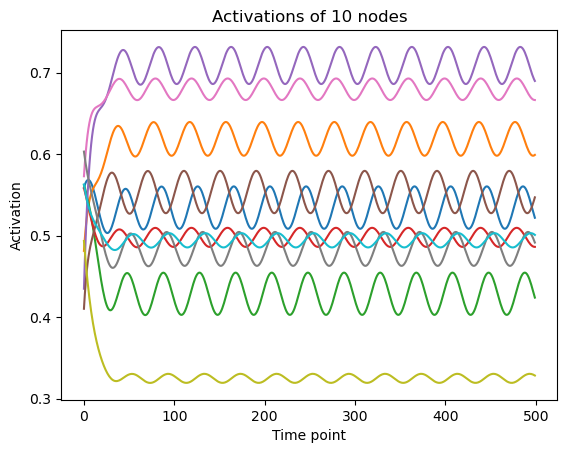

In [10]:
all_xs_ff_init = np.concatenate(xs_ff_init, axis=1)
for i in range(10, 20):
    plt.plot(all_xs_ff_init[i,0:500], label=f"Node {i}")
plt.xlabel("Time point")
plt.ylabel("Activation")
plt.title("Activations of 10 nodes")
if SAVEFIG:
    plt.savefig("fig/FORCE_ff_activations_0424.png")

In [11]:
peaks = []
start = 500
end = start + 2*half_period
for i in range(num_nodes):
    y = all_xs_ff_init[i]
    p = np.argmax(y[start:end])
    peaks.append(p)
target_peak = np.argmax(targets[start:end])
relative_peaks_ff_init = np.array(peaks) - target_peak

# plus 120 for relative peaks less than 0
relative_peaks_ff_init[relative_peaks_ff_init < 0] += 2*half_period
relative_peaks_ff_init

array([12, 14, 29, 37,  8, 37,  7, 26, 16, 39,  6, 37,  8, 39,  3, 31, 39,
       11, 13, 14, 34, 15, 10, 32, 23,  8, 12,  9,  4, 12, 19, 37, 26, 38,
        5, 11, 16, 39, 39, 20, 30, 20, 23, 15, 15,  6,  0, 19, 10,  2, 20,
        5,  0, 18, 28, 10, 25, 23, 38, 25, 23, 13,  7,  1, 31,  7, 20,  8,
       15, 38,  8, 23, 24,  9, 12, 25, 13,  4, 21,  5, 32, 39, 20, 22, 38,
       18, 17, 36, 39, 15, 34, 19, 37, 18, 15, 29, 30, 23, 24, 29,  1, 31,
       29, 38, 28, 33, 22, 24, 17,  1, 24, 12, 12, 17, 26, 19,  8,  4, 23,
        2,  8,  1, 11, 11, 33, 16, 26, 19, 25, 36, 38,  6,  4, 39, 14,  9,
       15, 10,  3, 28, 26, 37, 30, 24, 26, 33, 24, 22, 23,  5, 12,  2, 36,
       31, 35,  9, 25, 29,  8,  6,  3, 36, 29, 27, 11,  3, 27, 32, 11, 17,
       17,  8, 16, 26, 29, 25,  3, 15, 21, 11,  9, 27, 26, 25, 23, 16, 39,
       36,  7, 12,  9, 24, 22, 13,  3,  2, 26,  2, 12, 23])

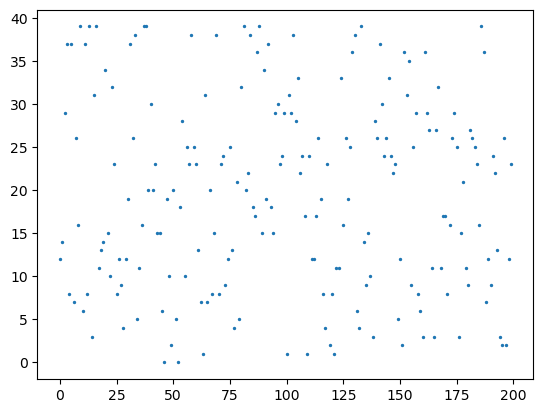

In [12]:
plt.scatter(np.arange(num_nodes), relative_peaks_ff_init, s=2)

### Discrete Tracking Control

In [13]:
# calculate the desired output before the output sigmoid
gainout= 2.5 # 1.15
shiftout= -2 # -2.5
y_tildes = (inv_sigmoid_np(targets) + shiftout) / gainout

In [14]:
# Simulate with control
x = init_state.copy()
u = init_state.copy() * 0
xs_fb, us_fb, outputs_fb_beforesig, outputs_fb = [x], [], [], []

# constants
R = np.eye(num_nodes) * 0.0001
Q1 = np.eye(num_nodes) * 0.01
Q2 = np.eye(1) * 10

for t in tqdm(time_points[:-1]):

    # jnn.i = t

    # output
    output_beforesig = output_weight_matrix @ x
    output = sigmoid_np(gainout * output_beforesig - shiftout)

    # # input
    # this_input = inputs[:,t]
    # r = feedback_weight_matrix * this_input.reshape(-1,1)
    
    # linear approxmation of nonlinear system
    # linear approximate F and G
    F, G, _ = jnn.jacob(x, u, r)   # x_t, u_t-1, r_t
    c = jnn.f(x, u, r) - F @ x - G @ u  # the constant term after approximation
    # augment the system for the constant term
    F_aug = np.concatenate([np.concatenate([F, np.eye(num_nodes)], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.eye(num_nodes)], axis=1)], axis=0)
    G_aug = np.concatenate([G, np.zeros((num_nodes, num_nodes))], axis=0)
    x_aug = np.concatenate([x, c], axis=0)

    # get H
    H = output_weight_matrix.T
    L = H @ np.linalg.inv(H.T @ H)
    H_bar = (np.eye(num_nodes) - L @ H.T).T
    Q = H_bar @ Q1 @ H_bar.T + H @ Q2 @ H.T
    y_tilde = y_tildes[t+1]
    x_tilde = L @ np.array([[y_tilde]])
    x_tilde_aug = np.concatenate([x_tilde, c], axis=0)
    # Q_aug = np.concatenate([np.concatenate([Q, np.zeros((num_nodes, num_nodes))], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.eye(num_nodes)], axis=1)], axis=0)
    Q_aug = np.concatenate([np.concatenate([Q, np.zeros((num_nodes, num_nodes))], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.zeros((num_nodes, num_nodes))], axis=1)], axis=0)

    # get the control input u
    # backward solve
    S_t2 = Q_aug
    b_t2 = np.zeros(shape=(2 * num_nodes, 1))
    S_t1 = F_aug.T @ (S_t2 - S_t2 @ G_aug @ np.linalg.inv(G_aug.T @ S_t2 @ G_aug + R) @ G_aug.T @ S_t2) @ F_aug + Q_aug
    K_T_t1 = -np.linalg.inv(G_aug.T @ S_t2 @ G_aug + R) @ G_aug.T @ S_t2 @ F_aug
    b_t1 = (F_aug.T + K_T_t1.T @ G_aug.T) @ b_t2 - Q_aug @ x_tilde_aug
    # calculate u_t
    u1 = -np.linalg.inv(G_aug.T @ S_t1 @ G_aug + R) @ G_aug.T @ (S_t1 @ F_aug @ x_aug + b_t1)
    # u = np.linalg.pinv(G) @ (G @ u1 - B @ r)
    # update u
    u = u1.copy()
    
    # input
    this_input = inputs[:,t]
    r = feedback_weight_matrix * this_input.reshape(-1,1)

    # update x
    x1 = jnn.f(x, u, r)
    # x1_0 = F @ x + G @ u + c
    # x1_1 = F_aug @ x_aug + G_aug @ u
    # print(np.linalg.norm(x1_0-x1))
    # print(np.linalg.norm(x1_1[0:num_nodes,:]-x1))
    x = x1.copy()
    
    # save
    xs_fb.append(x)
    us_fb.append(u)
    outputs_fb_beforesig.append(output_beforesig.item())
    outputs_fb.append(output.item())

# final readout for x_T
output_beforesig = output_weight_matrix @ x
output = sigmoid_np(gainout * output_beforesig - shiftout)
outputs_fb_beforesig.append(output_beforesig.item())
outputs_fb.append(output.item())

  0%|          | 0/7999 [00:00<?, ?it/s]

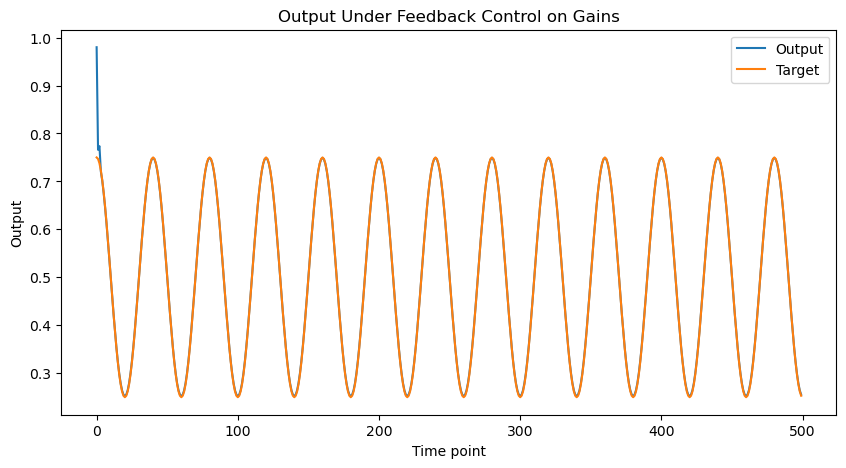

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points[0:500], outputs_fb[0:500], label='Output')
plt.plot(time_points[0:500],targets[0:500], label='Target')
plt.title('Output Under Feedback Control on Gains')
plt.xlabel('Time point')
plt.ylabel('Output')
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_tracking_output_0424.png")

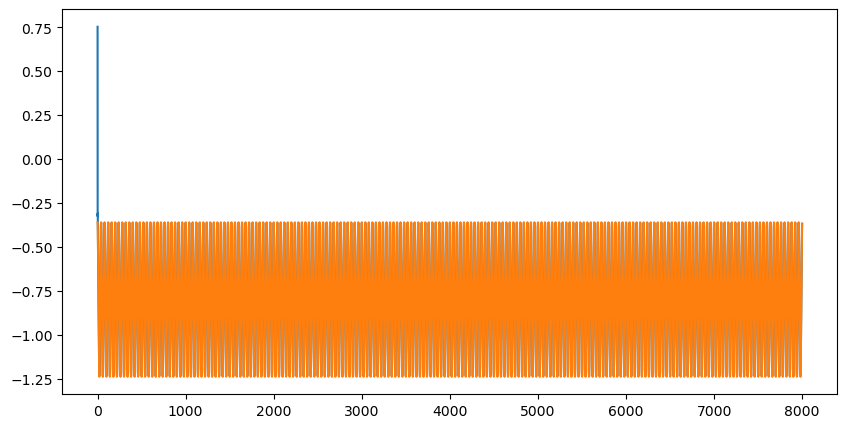

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(outputs_fb_beforesig)
plt.plot(y_tildes)

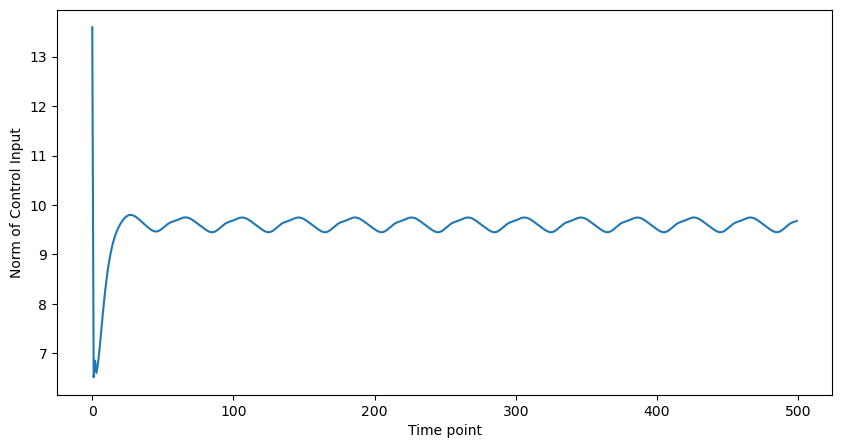

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
us_norm = [np.linalg.norm(u) for u in us_fb]

plt.plot(us_norm[0:500])
plt.ylabel('Norm of Control Input')
plt.xlabel('Time point')
if SAVEFIG:
    plt.savefig("fig/FORCE_tracking_unorm_0424.png")

### Discrete Tracking Control Plus Hebbian Learning

In [33]:
# calculate the desired output before the output sigmoid
gainout= 2.5 # 1.15
shiftout= -2 # -2.5
out_lr = 0.002
y_tildes = inv_sigmoid_np(targets) / gainout  + shiftout

In [34]:
# Simulate with control
x = init_state.copy()
u = init_state.copy() * 0
this_output_weight_matrix = output_weight_matrix.copy()
xs_hebb, us_hebb, outputs_hebb_beforesig, outputs_hebb = [x], [], [], []
has_hebbian = False
adjust_out = False

# constants
R = np.eye(num_nodes) * 0.0001
Q1 = np.eye(num_nodes) * 0.01
Q2 = np.eye(1) * 10
hebbian_lr = 0.01
u_scale = 1

for t in tqdm(time_points[:-1]):

    # jnn.i = t

    # output
    output_beforesig = this_output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))

    # update readout weights by hebbian learning
    if not has_hebbian and 1000 < t < 2000:
        has_hebbian = True
        x_mean = np.concatenate(xs_hebb, axis=1).mean(axis=1).reshape(-1, 1)
        x_std = np.concatenate(xs_hebb, axis=1).std(axis=1).reshape(-1, 1)
        # output_mean = np.array(outputs_fb).mean()
        output_mean = 0.5
        # target_mean = 0.5
    
    # start adjusting the output gains and shifts
    if t > 2000:
        adjust_out = True
        has_hebbian = False
        period = 2 * half_period
    
    if has_hebbian:
        # this_target = targets[t]
        # Calculate Hebbian weight updates
        # hebbian_update = (this_target - target_mean) * ((x - x_mean) / x_std).T
        hebbian_update = (output - output_mean) * ((x - x_mean) / x_std).T
        # hebbian_update = output * x.T
        # hebbian_update = hebbian_update * node_type
        # Normalized Hebbian learning
        tmp_output_weight_matrix = this_output_weight_matrix + hebbian_lr * hebbian_update
        tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
        tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
        tmp_ext[tmp_ext < 0] = 0
        tmp_inh[tmp_inh > 0] = 0
        tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
        tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
        tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
        tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
        # update init weights
        this_output_weight_matrix = tmp_output_weight_matrix.copy()
    
    # adjust the gainout and shiftout
    if adjust_out:
        mean_output = np.mean(outputs_hebb[t-period:t])
        amplitude = np.max(outputs_hebb[t-period:t]) - np.min(outputs_hebb[t-period:t])
        if np.abs(mean_output - 0.5) > 0.01:
            shiftout += out_lr * np.sign(mean_output - 0.5)
        if np.abs(amplitude - 0.5) > 0.01:
            gainout -= out_lr * np.sign(amplitude - 0.5)

    # input
    this_input = inputs[:,t]
    r = feedback_weight_matrix * this_input.reshape(-1,1)
    
    # linear approxmation of nonlinear system
    # linear approximate F and G
    F, G, _ = jnn.jacob(x, u, r)   # x_t, u_t-1
    c = jnn.f(x, u, r) - F @ x - G @ u  # the constant term after approximation
    # augment the system for the constant term
    F_aug = np.concatenate([np.concatenate([F, np.eye(num_nodes)], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.eye(num_nodes)], axis=1)], axis=0)
    G_aug = np.concatenate([G, np.zeros((num_nodes, num_nodes))], axis=0)
    x_aug = np.concatenate([x, c], axis=0)

    # get H
    H = this_output_weight_matrix.T
    L = H @ np.linalg.inv(H.T @ H)
    H_bar = (np.eye(num_nodes) - L @ H.T).T
    Q = H_bar @ Q1 @ H_bar.T + H @ Q2 @ H.T
    y_tilde = y_tildes[t+1]
    x_tilde = L @ np.array([[y_tilde]])
    x_tilde_aug = np.concatenate([x_tilde, c], axis=0)
    # Q_aug = np.concatenate([np.concatenate([Q, np.zeros((num_nodes, num_nodes))], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.eye(num_nodes)], axis=1)], axis=0)
    Q_aug = np.concatenate([np.concatenate([Q, np.zeros((num_nodes, num_nodes))], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.zeros((num_nodes, num_nodes))], axis=1)], axis=0)

    # get the control input u
    # backward solve
    S_t2 = Q_aug
    b_t2 = np.zeros(shape=(2 * num_nodes, 1))
    S_t1 = F_aug.T @ (S_t2 - S_t2 @ G_aug @ np.linalg.inv(G_aug.T @ S_t2 @ G_aug + R) @ G_aug.T @ S_t2) @ F_aug + Q_aug
    K_T_t1 = -np.linalg.inv(G_aug.T @ S_t2 @ G_aug + R) @ G_aug.T @ S_t2 @ F_aug
    b_t1 = (F_aug.T + K_T_t1.T @ G_aug.T) @ b_t2 - Q_aug @ x_tilde_aug
    # calculate u_t
    u1 = -np.linalg.inv(G_aug.T @ S_t1 @ G_aug + R) @ G_aug.T @ (S_t1 @ F_aug @ x_aug + b_t1)
    # update u
    u = u1.copy()
    
    if adjust_out:
        u_scale *= 0.99
        u = u_scale * u
    
    # # input
    # this_input = inputs[:,t]
    # r = feedback_weight_matrix * this_input.reshape(-1,1)

    # update x
    x1 = jnn.f(x, u, r)
    # x1_0 = F @ x + G @ u + c
    # x1_1 = F_aug @ x_aug + G_aug @ u
    # print(np.linalg.norm(x1_0-x1))
    # print(np.linalg.norm(x1_1[0:num_nodes,:]-x1))
    x = x1.copy()
    
    # save
    xs_hebb.append(x)
    us_hebb.append(u)
    outputs_hebb_beforesig.append(output_beforesig.item())
    outputs_hebb.append(output.item())

# final readout for x_T
output_beforesig = this_output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_hebb_beforesig.append(output_beforesig.item())
outputs_hebb.append(output.item())

  0%|          | 0/7999 [00:00<?, ?it/s]

In [35]:
gainout, shiftout

(1.4040000000000545, 0.5300000000000021)

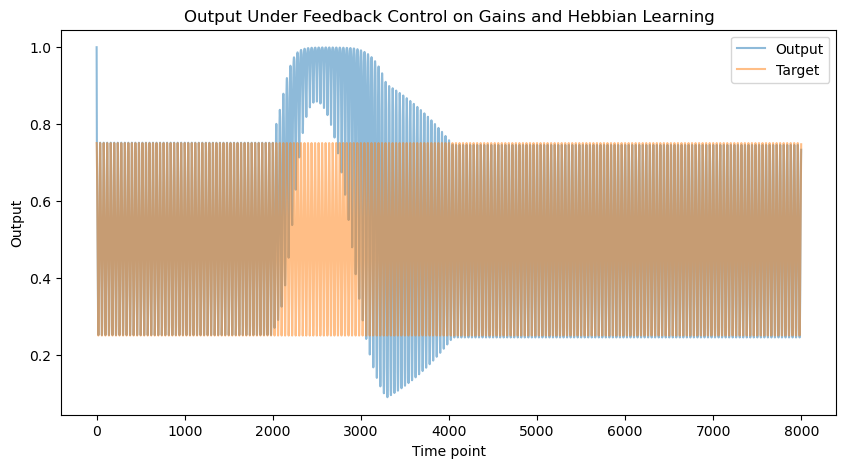

In [48]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_hebb, label='Output', alpha=0.5)
plt.plot(time_points, targets, label='Target', alpha=0.5)
plt.title('Output Under Feedback Control on Gains and Hebbian Learning')
plt.xlabel('Time point')
plt.ylabel('Output')
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_hebb_output_0510.png")

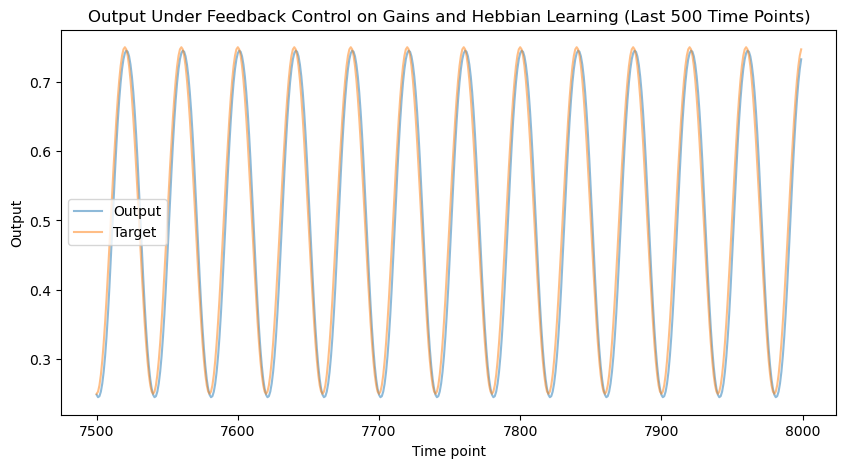

In [49]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points[-500:], outputs_hebb[-500:], label='Output', alpha=0.5)
plt.plot(time_points[-500:], targets[-500:], label='Target', alpha=0.5)
plt.title('Output Under Feedback Control on Gains and Hebbian Learning (Last 500 Time Points)')
plt.xlabel('Time point')
plt.ylabel('Output')
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_hebb_last_output_0510.png")

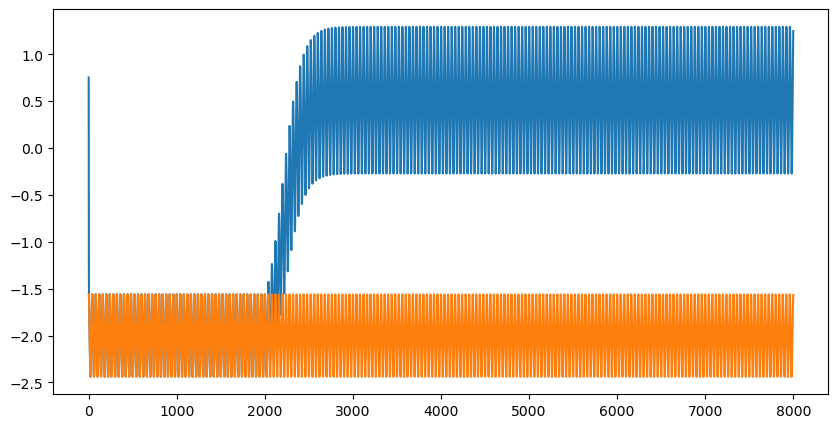

In [50]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(outputs_hebb_beforesig)
plt.plot(y_tildes)

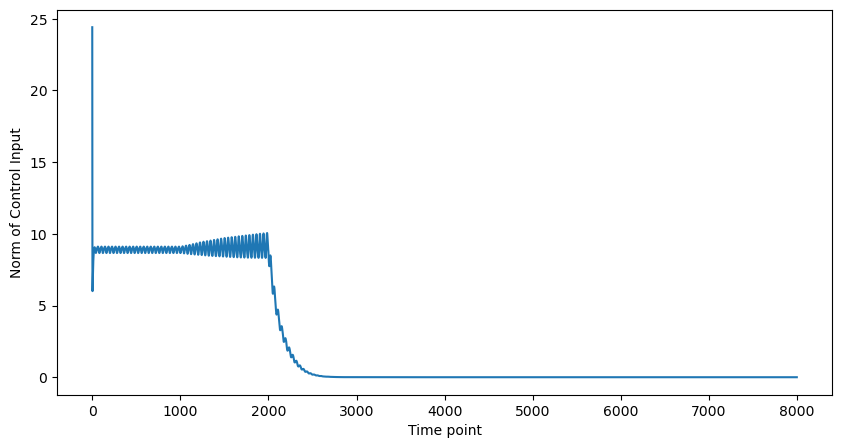

In [51]:
fig, ax = plt.subplots(figsize=(10, 5))
us_norm = [np.linalg.norm(u) for u in us_hebb]

plt.plot(us_norm)
plt.ylabel('Norm of Control Input')
plt.xlabel('Time point')
if SAVEFIG:
    plt.savefig("fig/FORCE_hebb_unorm_0510.png")

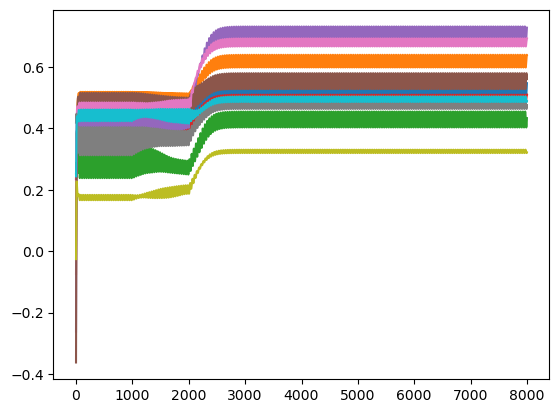

In [40]:
all_xs_hebb = np.concatenate(xs_hebb, axis=1)
for i in range(10, 20):
    plt.plot(all_xs_hebb[i,:], label=f"Node {i}")

In [41]:
peaks = []
start = 1500
end = start + 2*half_period
for i in range(num_nodes):
    y = all_xs_hebb[i]
    p = np.argmax(y[start:end])
    peaks.append(p)
target_peak = np.argmax(targets[start:end])
relative_peaks_hebb = np.array(peaks) - target_peak

# plus 120 for relative peaks less than 0
relative_peaks_hebb[relative_peaks_hebb < 0] += 2*half_period
relative_peaks_hebb

array([24, 19, 26, 35, 31, 15, 24, 26, 20, 33,  3, 22,  9, 31, 21, 35, 14,
       15, 22, 22, 33, 22, 20, 29, 26, 12, 15, 20, 39, 25, 20, 13,  9, 27,
       21, 25, 20, 18, 33, 23, 27, 28, 30, 18, 18, 28, 29, 25, 13,  0, 21,
        4, 35, 20, 26, 24, 24, 12, 31, 28, 24, 27, 26, 38, 11,  7,  3, 18,
       18, 34, 12, 27, 27, 26, 15, 25, 25, 24, 22,  3, 30, 36, 23, 24, 33,
       24, 27, 33, 19, 35, 15, 25, 15, 21, 17, 26, 28, 28, 10, 13,  3, 35,
       30, 34, 28, 30, 25, 34, 35, 37, 27,  9, 12, 20,  7, 26,  9, 39, 25,
       31,  9, 39, 37,  8, 30, 19, 30, 22,  4, 30, 35,  5, 34, 33, 35, 30,
       35, 14,  8, 28, 26, 27, 30, 25, 29, 30, 30, 26, 26,  4, 13, 32, 16,
       31, 33,  5, 26,  5, 10,  5, 37,  4, 29, 28,  8,  0, 28,  6, 12, 28,
       38,  7, 20, 10, 29, 10, 32, 37, 25, 30, 30,  5, 26, 26, 29, 21, 32,
       35, 33, 21,  8,  5, 29, 15, 34,  4, 27, 30, 16, 30])

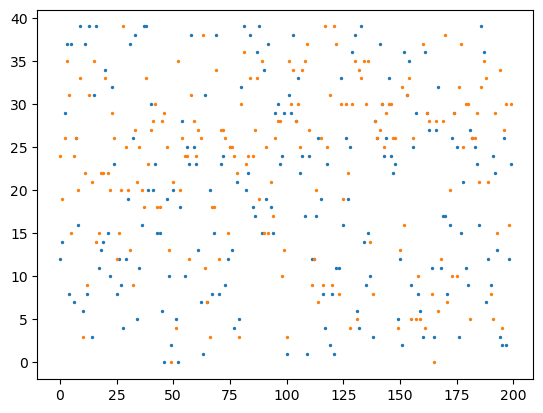

In [42]:
plt.scatter(np.arange(num_nodes), relative_peaks_ff_init, s=2)
plt.scatter(np.arange(num_nodes), relative_peaks_hebb, s=2)

In [28]:
# this_output_weight_matrix = this_output_weight_matrix / x_mean.T / 100

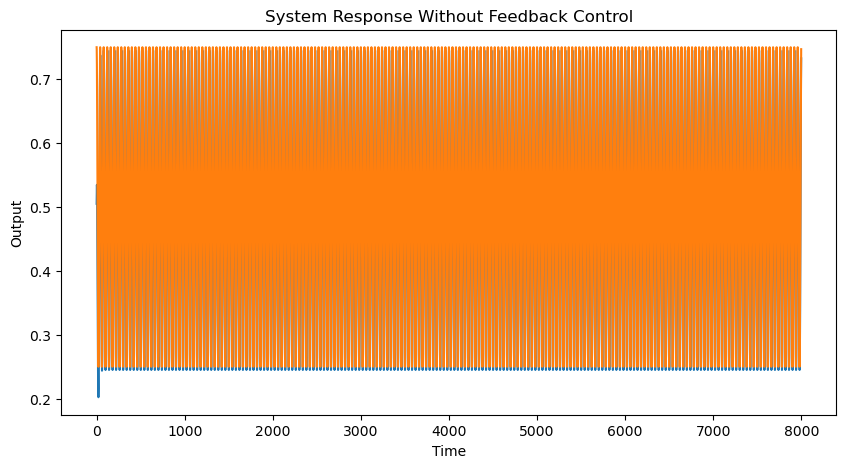

In [43]:
# Simulation Without Control
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
u = init_state.copy() * 0
xs_ff_after, outputs_ff_after = [x], []
# gainout = 1.5 # 1
# shiftout = 1 # -1.6

for i in time_points[:-1]:

    # output
    output_beforesig = this_output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))

    # input
    this_input = inputs[:,i]
    r = feedback_weight_matrix * this_input.reshape(-1, 1)
    
    # update x
    x1 = jnn_ff.f(x, u, r)
    x = x1.copy()

    # save
    xs_ff_after.append(x)
    outputs_ff_after.append(output.item())

# final readout for x_T
output_beforesig = this_output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_ff_after.append(output.item())

# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_ff_after)
plt.plot(time_points, targets)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

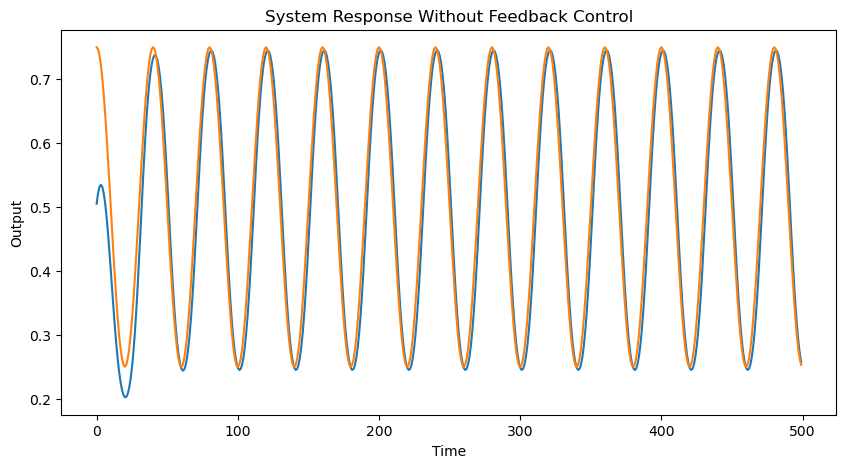

In [44]:
# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points[0:500], outputs_ff_after[0:500])
plt.plot(time_points[0:500], targets[0:500])
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
if SAVEFIG:
    plt.savefig("fig/FORCE_ff_outputs_after_0424.png")

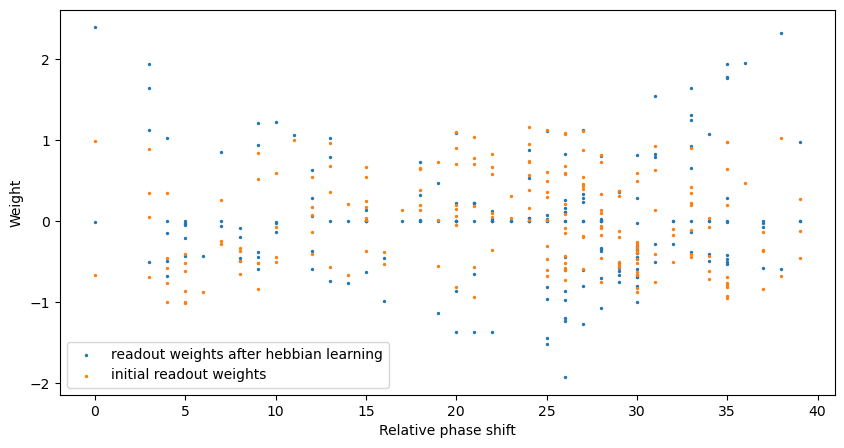

In [45]:
plt.subplots(figsize=(10, 5))
plt.scatter(relative_peaks_hebb, this_output_weight_matrix.flatten(), s=2, label="readout weights after hebbian learning")
plt.scatter(relative_peaks_hebb, output_weight_matrix.flatten(), s=2, label="initial readout weights")
plt.xlabel("Relative phase shift")
plt.ylabel("Weight")
plt.legend()

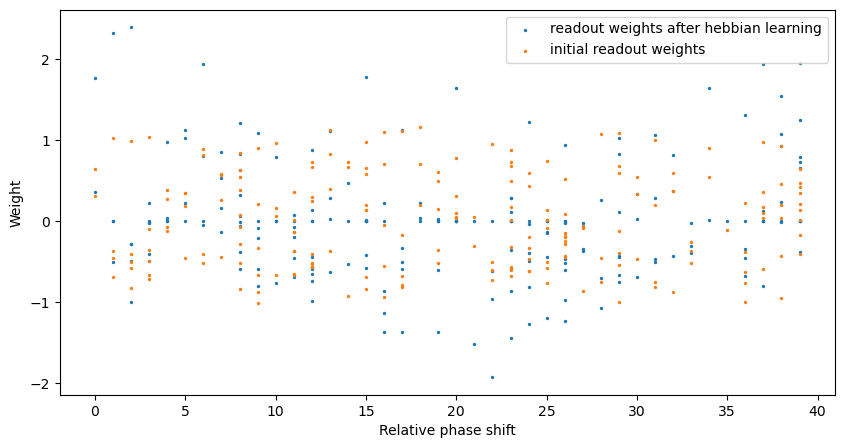

In [52]:
plt.subplots(figsize=(10, 5))
plt.scatter(relative_peaks_ff_init, this_output_weight_matrix.flatten(), s=2, label="readout weights after hebbian learning")
plt.scatter(relative_peaks_ff_init, output_weight_matrix.flatten(), s=2, label="initial readout weights")
plt.xlabel("Relative phase shift")
plt.ylabel("Weight")
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_weight_phase_0510.png")